In [2]:
import sys
sys.path.append("./models")
sys.path.append("./datasets")

In [3]:
import torch
from torch.utils.data import DataLoader
from feature_extractors import ResNet18FeatureExtractor
from deep_svdd import DeepSVDD
from cifar10_loader import CIFAR10OneClass


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan aygıt:", device)

# Dataset ve Dataloader
train_dataset = CIFAR10OneClass(
    root="./datasets",
    normal_class=5,
    train=True
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# Model ve Optimizer
feature_extractor = ResNet18FeatureExtractor().to(device)
svdd = DeepSVDD(feature_dim=512).to(device)
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=1e-4)

# Center Başlat
svdd.init_center(feature_extractor, train_loader, device)

# Eğitim Döngüsü
feature_extractor.train()
num_epochs = 2  # hızlı test için
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        dists = svdd(feats)
        loss = torch.mean(dists)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Kullanılan aygıt: cuda
[Epoch 1/5] Loss: 250.6856
[Epoch 2/5] Loss: 150.9301
[Epoch 3/5] Loss: 141.6927
[Epoch 4/5] Loss: 138.6512
[Epoch 5/5] Loss: 136.6997


In [37]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

# Test setini yükle
test_dataset = CIFAR10OneClass(
    root="./datasets",
    normal_class=0,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Değerlendirme modu
feature_extractor.eval()
svdd.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        scores = svdd(feats)  # uzaklık
        y_scores += scores.cpu().numpy().tolist()
        y_true += labels.numpy().tolist()

# y_true = 0 (normal), 1 (anomaly)
# y_scores = uzaklık skoru (ne kadar uzaksa o kadar anomali)

# ROC AUC hesapla
auc = roc_auc_score(y_true, y_scores)

# Eşikleme için: medyanı kullan (isteğe bağlı olarak mean veya %95 quantile da olur)
threshold = np.median(y_scores)
y_pred = [1 if s > threshold else 0 for s in y_scores]

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"\n Evaluation Results:")
print(f"AUC:     {auc:.4f}")
print(f"F1 Score:{f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")



📊 Evaluation Results:
AUC:     0.4624
F1 Score:0.6346
Precision: 0.8884
Recall:    0.4936


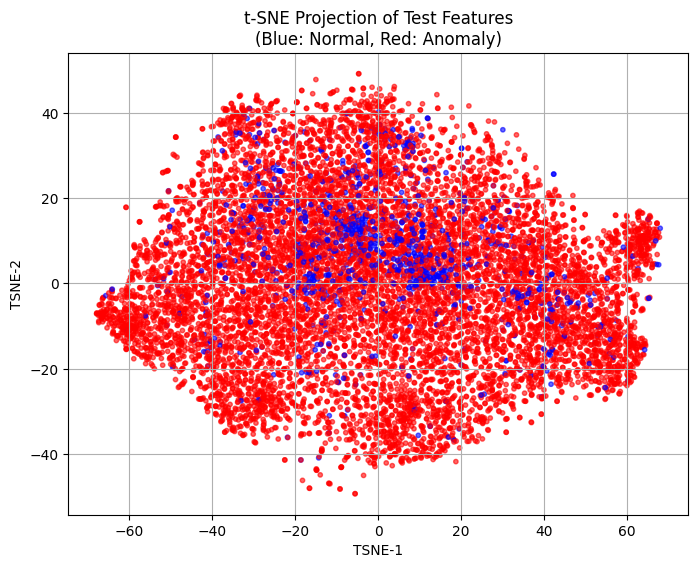

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

# Özellikleri ve etiketleri topla
all_features = []
all_labels = []

feature_extractor.eval()
with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        all_features.append(feats.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Listeyi array'e çevir
all_features = np.concatenate(all_features, axis=0)
all_labels = np.array(all_labels)

# t-SNE ile boyut indirgeme
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Görselleştir
plt.figure(figsize=(8, 6))
colors = ['blue' if l == 0 else 'red' for l in all_labels]
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, alpha=0.6, s=10)
plt.title("t-SNE Projection of Test Features\n(Blue: Normal, Red: Anomaly)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


In [28]:
%%writefile ./models/feature_extractors.py
import torch.nn as nn
from torchvision.models import resnet18, mobilenet_v2

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

class MobileNetV2FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = mobilenet_v2(weights='DEFAULT')
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # mobilenet output 1280x1x1

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return x.view(x.size(0), -1)


Overwriting /content/drive/MyDrive/deep-occ-anomaly/models/feature_extractors.py


In [29]:
import importlib
import sys

sys.path.append("./models")
import feature_extractors
importlib.reload(feature_extractors)  # bu çok kritik
from feature_extractors import MobileNetV2FeatureExtractor


In [30]:
# === MOBILE NET V2 + SVDD EĞİTİM ===

import importlib
import sys
sys.path.append("./models")
sys.path.append("./datasets")

import torch
from torch.utils.data import DataLoader
import feature_extractors
importlib.reload(feature_extractors)
from feature_extractors import MobileNetV2FeatureExtractor
from deep_svdd import DeepSVDD
from cifar10_loader import CIFAR10OneClass

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan aygıt:", device)

# Dataset
train_dataset = CIFAR10OneClass(
    root="./datasets",
    normal_class=0,  # airplane
    train=True
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# MODEL
feature_extractor = MobileNetV2FeatureExtractor().to(device)
svdd = DeepSVDD(feature_dim=1280).to(device)
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=1e-4)

# CENTER başlat
svdd.init_center(feature_extractor, train_loader, device)

# EĞİTİM
feature_extractor.train()
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        dists = svdd(feats)
        loss = torch.mean(dists)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Kullanılan aygıt: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


[Epoch 1/5] Loss: 78.1420
[Epoch 2/5] Loss: 42.2211
[Epoch 3/5] Loss: 34.6622
[Epoch 4/5] Loss: 32.0150
[Epoch 5/5] Loss: 30.9772


In [31]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

# Test seti
test_dataset = CIFAR10OneClass(
    root="./datasets",
    normal_class=0,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Değerlendirme
feature_extractor.eval()
svdd.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        scores = svdd(feats)  # uzaklık skoru
        y_scores += scores.cpu().numpy().tolist()
        y_true += labels.numpy().tolist()

# Skorlama
auc = roc_auc_score(y_true, y_scores)
threshold = np.median(y_scores)
y_pred = [1 if s > threshold else 0 for s in y_scores]
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"\n Evaluation Results:")
print(f"AUC:     {auc:.4f}")
print(f"F1 Score:{f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")



📊 Evaluation Results:
AUC:     0.5607
F1 Score:0.6579
Precision: 0.9210
Recall:    0.5117


In [38]:
%%writefile ./models/feature_extractors.py
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import glob

class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None, phase='train'):
        self.root_dir = root_dir
        self.phase = phase  # 'train' or 'test'
        self.transform = transform

        self.image_paths = []
        self.labels = []

        if self.phase == 'train':
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, 'train', '*', '*.png')))
            self.labels = [0] * len(self.image_paths)  # all normal
        else:
            defect_types = os.listdir(os.path.join(root_dir, 'test'))
            for defect_type in defect_types:
                img_dir = os.path.join(root_dir, 'test', defect_type)
                img_paths = sorted(glob.glob(os.path.join(img_dir, '*.png')))
                self.image_paths += img_paths
                label = 0 if defect_type == 'good' else 1
                self.labels += [label] * len(img_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


Writing /content/drive/MyDrive/deep-occ-anomaly/datasets/mvtec_loader.py


In [40]:
import sys
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from mvtec_loader import MVTecDataset
from feature_extractors import MobileNetV2FeatureExtractor
from deep_svdd import DeepSVDD

sys.path.append("./models")
sys.path.append("./datasets")

# Aygıt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan aygıt:", device)

# Transformlar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset & Loader
train_dataset = MVTecDataset(
    root_dir="./datasets/mvtec_anomaly_detection/bottle",
    transform=transform,
    phase="train"
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Model
feature_extractor = MobileNetV2FeatureExtractor().to(device)
svdd = DeepSVDD(feature_dim=1280).to(device)
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=1e-4)

# Center init
svdd.init_center(feature_extractor, train_loader, device)

# Eğitim
feature_extractor.train()
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        dists = svdd(feats)
        loss = torch.mean(dists)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Kullanılan aygıt: cuda
[Epoch 1/5] Loss: 169.2414
[Epoch 2/5] Loss: 143.4884
[Epoch 3/5] Loss: 129.6238
[Epoch 4/5] Loss: 119.4745
[Epoch 5/5] Loss: 110.5593


In [41]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from mvtec_loader import MVTecDataset
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Test dataseti
test_dataset = MVTecDataset(
    root_dir="./datasets/mvtec_anomaly_detection/bottle",
    transform=transform,
    phase="test"
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Test işlemi
feature_extractor.eval()
svdd.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        feats = feature_extractor(x)
        scores = svdd(feats)
        y_scores += scores.cpu().numpy().tolist()
        y_true += labels.numpy().tolist()

# Skor değerlendirme
auc = roc_auc_score(y_true, y_scores)
threshold = np.median(y_scores)
y_pred = [1 if s > threshold else 0 for s in y_scores]
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"\n Evaluation Results:")
print(f"AUC:     {auc:.4f}")
print(f"F1 Score:{f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")



📊 Evaluation Results:
AUC:     0.8595
F1 Score:0.7692
Precision: 0.9756
Recall:    0.6349


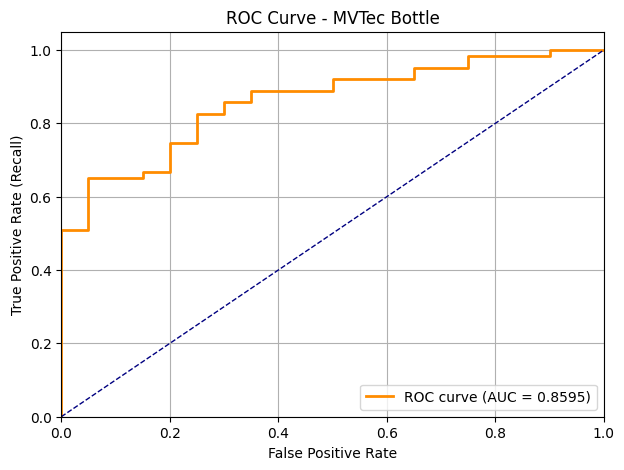

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve verileri
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC eğrisi çizimi
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - MVTec Bottle')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
